# Analyse d’un modèle avec demandes, stockage hydroélectrique et gaz

### Import des librairies utilisées pour résoudre les problèmes

In [1]:
import numpy as np
from fileData import FileData
import matplotlib.pyplot as plt

import cvxpy as cp
from scipy.optimize import linprog

### Variables communes

In [2]:
# Couts d'installation amortis des éoliennes
cout_instal_onshore  = 168903 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
cout_instal_offshore = 300336 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)

# Couts d'installation amortis et coûts de fonctionnement des centrales au gaz
cout_instal_gaz = 94956 # Coût *amorti sur un an* pour l'installation d'un MW de centrale au gaz (euros/MW/an)
cout_fonct_gaz  = 65    # Coût de fonctionnement pour la production d'un MWh par centrale au gaz (euros/MWh)

# Stockage disponible par pays (en MWh)
stockage = [0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]

# Puissances maximales de turbinage et de pompage disponibles par pays (en MW)
turbinage = [8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101]
pompage   = [5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ]

# Rendement pour le turbinage (sans unité)
heta = 0.85

#Nombre d'éoliennes onshore et offshore
n_t = 487
n_m = 155
n = n_t + n_m

### Extraction des données partagées dans les modèles

In [3]:
data = FileData()

# Matrice de la consommation agrégée
Demandes = np.sum(data.getConsoData(), axis=0)
# Rendement des éoliennes onshore et offshore
Rendements = data.getRend()
# Capacités électriques éolien
c_t = data.getOnshoreCapacites()
c_m = data.getOffshoreCapacites()
c = np.concatenate((c_t,c_m))
# Apports naturels hydroélectriques agrégés
Water = np.sum(data.getHydroData(), axis=0)

### Variables temporelles

In [4]:
# Horizon temporel de résolution
"""
1 jour            : 24
1 semaine         : 168
1 mois (30 jours) : 720
3 mois (1/4 an)   : 2190
6 mois (1/2 an)   : 4380 
1 an   (365 jours): 8760
"""
h = 8190

# Longueur de la période utilisée
T = 3

# Nombre de périodes
t = h//T

In [5]:
# Réduction à l'horizon temporel considéré
D = Demandes[:h]
R = Rendements[:,:h]
W = Water[:h]

### Fonctions communes
Fonctions communes à tous les modèles

In [7]:
def periodisation(A, T):
    """
    Additionne toutes les valeurs de A dans une même période.
    input A : Matrice à périodiser
    !! Le nombre de colonnes (axis = 1) représente le temps (l'horizon temporel) !!
    input T : Longueur de la période
    output : Matrice A périodisée
    """
    # p : nombre de période
    # r : reste du nombre de période
    p = A.shape[1] // T
    r = A.shape[1] % T
    # On coupe la matrice car sinon il n'y a pas assez de données de remplir la dernière période
    A = A[:,:-r] if r!=0 else A
    # C : matrice pour additionner les productions d'une période
    C = np.zeros((A.shape[1], p))
    for i in range(p):
        C[i * T:(i + 1) * T, i] = 1
    # P : matrice périodisée
    P = np.dot(A, C)
    return P

def E_eolienne(R, c, T):
    A = np.zeros(R.shape)
    for i in range(len(c)):
        A[i] = c[i] * R[i]
        
    A = periodisation(A, T)
    return A

### Produits des fonctions communes
Variables communes nécessitant un calcul

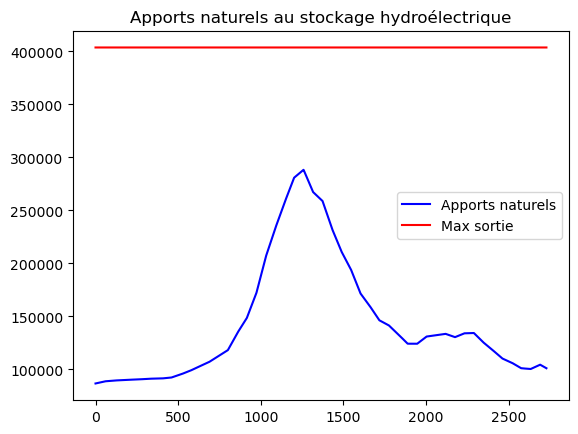

In [8]:
# Périodisation de D
d = periodisation(np.array([D]), T)
d = np.transpose(d)
# E : matrice de la production éolienne par site par période
E = E_eolienne(R, c, T)
# s : scalaire, stockage total hydroélectrique
s = np.sum(stockage)
# pPompage : scalaire, puissance de pompage totale
pPompage = np.sum(pompage)
# pTurbinage : scalaire, puissance de turbinage totale
pTurbinage = np.sum(turbinage)
# Périodisation de W
wA = periodisation(np.array([W]), T)
wA = np.transpose(wA)
# Matrice L
L = np.tril(np.ones((t,t)))

plt.plot(np.arange(t), wA, 'b', label="Apports naturels")
plt.plot(np.arange(t), heta*T*pTurbinage*np.ones((t)), 'r', label="Max sortie")
plt.title("Apports naturels au stockage hydroélectrique")
plt.legend()
plt.show()

## Modèle 4
On considère d’abord un modèle européen agrégé avec installation d’éoliennes et utilisation des capacités hydroélectriques, mais pas de centrales au gaz. Ce modèle agrégé ne possède donc qu’une seule entité pour la production, le stockage et la consommation d’électricité (additionnez les capacités hydroélectriques et les demandes de tous les pays qui la composent).
On chercher à calculer la valeur minimale du prix moyen de l’électricité consommée.

### Resolution CVXPY

In [ ]:
# Variables : portions des sites installés, quantités pompées, quantités turbinées
x = cp.Variable((n,1))
wP = cp.Variable((t,1))
wT = cp.Variable((t,1))

# Vecteur des prix d'installation d'éolienne onshore et offshore
cost = (h/8760)*np.concatenate((cout_instal_onshore * c_t, cout_instal_offshore * c_m))

# Contraintes
contraintes = [
    x >= 0, x <= 1, 
    E.T@x - wP + wT >= d,
    0 <= s/2 + L@(wA + wP - wT/heta), s/2 + L@(wA + wP - wT/heta) <= s,
    np.ones((1,t))@(wA + wP - wT/heta) == 0,
    0 <= wP, wP <= T*pPompage,
    0 <= wT, wT <= heta*T*pTurbinage,
    wP <= E.T@x
    ]

# Probleme
prob = cp.Problem(cp.Minimize(cost @ x), contraintes)


In [ ]:
# Resolution
prob.solve()
print(prob.status)

In [ ]:
# Get values
prixtot = prob.value
x = x.value
wP = wP.value
wT = wT.value

### Resolution SCIPY

In [9]:
# Variables : portions des sites installés, quantités pompées, quantités turbinées
#x = Variable((n,1))
#wP = Variable((t,1))
#wT = Variable((t,1))
#n + 2*t

# Vecteur des prix d'installation d'éolienne onshore et offshore
cost = (h/8760)*np.concatenate((cout_instal_onshore * c_t, cout_instal_offshore * c_m))
cost_all = np.concatenate((cost, np.zeros((2*t,))))

# Bounds
# x >= 0, x <= 1
# 0 <= wP, wP <= T*pPompage
# 0 <= wT, wT <= heta*T*pTurbinage

bounds = []
for i in range (n) :
    bounds.append((0,1))
for i in range (t) :
    bounds.append((0, T*pPompage))
for i in range(t) :
    bounds.append((0, heta*T*pTurbinage))

# Equality constraints
# sum(wP - wT/heta) == -sum(wA)

A_eq = np.concatenate((np.zeros((1,n)), np.ones((1,t)), (-1/heta)*np.ones((1,t))), axis=1)
b_eq = -np.sum(wA)

# Inequality contraints
# -E.T@x + wP - wT <= -d
# L@(-wP + wT/heta) <= s/2 + L@wA 
# L@(wP - wT/heta) <= s/2 - L@wA
# -E.T@x + wP <= 0

A_ub1 = np.concatenate((-E.T, np.identity(t), -np.identity(t)), axis=1)
b_ub1 = -d

A_ub2 = np.concatenate((np.zeros((t,n)), -L, L/heta), axis=1)
b_ub2 = 0.5*s + L@wA

# Manually increasing max stockage (factor = 1 means real value)
factor = 1
A_ub3 = np.concatenate((np.zeros((t,n)), L, -L/heta), axis=1)
b_ub3 = factor*0.5*s - L@wA 

A_ub4 = np.concatenate((-E.T, np.identity(t), np.zeros((t,t))), axis=1)
b_ub4 = np.zeros((t,1))

A_ub = np.concatenate((A_ub1, A_ub2, A_ub3, A_ub4))
b_ub = np.concatenate((b_ub1, b_ub2, b_ub3, b_ub4))

res = linprog(cost_all, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
print(res.message)


Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [10]:
# Get values

prixtot = res.fun
x = res.x[0:n]
wP = res.x[n:n+t]
wT = res.x[n+t:n+2*t]

### Results

In [11]:
# Energie produite (pour laquelle de l'argent a été dépensé)
Eprod = np.sum(E.T@x)

# Apports naturels
Enat = np.sum(wA)

# Energie utilisée
Eutile = np.sum(d)

print("Energie produite, {} MWh".format(Eprod))
print("Energie 'reçue' , {} MWh".format(Enat))
print("Total           , {} MWh".format(Eprod+Enat))
print("Energie utilisée, {} MWh".format(Eutile))

# Prix total, prix moyen
print("Prix total, {} euros".format(prixtot))
print("Prix moyen, {} euros/MWh".format(prixtot/Eprod))

Energie produite, 1718720186.0673025 MWh
Energie 'reçue' , 393278403.22609997 MWh
Total           , 2111998589.2934024 MWh
Energie utilisée, 1950922956.7 MWh
Prix total, 91796632543.60155 euros
Prix moyen, 53.40987630665259 euros/MWh


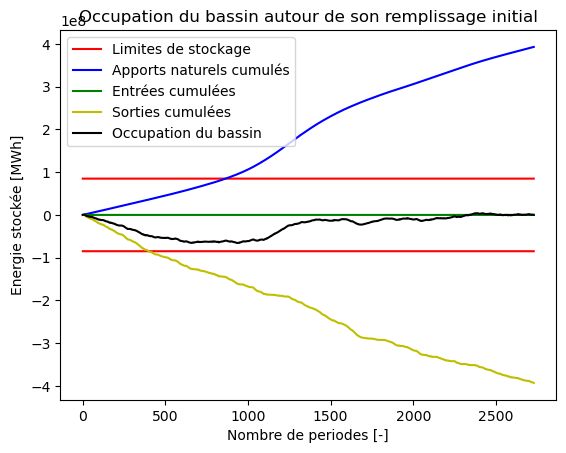

In [12]:
plt.figure()

time = np.arange(0,t,1)

min = -0.5*s*np.ones((t))
max = 0.5*s*np.ones((t))

apports = np.ravel(wA)
entrees = np.ravel(wP)
sorties = np.ravel(wT/heta)

plt.plot(time, min, 'r', label="Limites de stockage")
plt.plot(time, max, 'r')
plt.plot(time, L@apports, 'b', label="Apports naturels cumulés")
plt.plot(time, L@entrees, 'g', label="Entrées cumulées")
plt.plot(time, -L@sorties, 'y', label="Sorties cumulées")
plt.plot(time, L@(apports + entrees - sorties), 'black', label="Occupation du bassin")

plt.xlabel("Nombre de periodes [-]")
plt.ylabel("Energie stockée [MWh]")
plt.title("Occupation du bassin autour de son remplissage initial")
plt.legend()
plt.show()

## Modèle 5
Considérons le modèle 4 avec la contrainte supplémentaire suivante : sur chaque site  éolien potentiel, il faut choisir entre installer 100%, 50% ou 0% de la capacité maximale installable.

In [ ]:
# TODO

## Modèle 6
Revenons au modèle initial de la question 4 et incorporons la possibilité d’installer et d’utiliser des centrales au gaz.

In [ ]:
# TODO